In [17]:
import os

from numpy import save
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from models.DDPM import Unet, GaussianDiffusion, TrainerDDPM
from models.GBM import Unet, GBM, TrainerGBM

from utils.dataset import import_dataset

import argparse

os.umask(0o002)

# Define arguments

data_name='light_sheets_full'
dataset_path='/nfs/conditionalDDPM/data'
logdir='/nfs/conditionalDDPM/logs/light_sheets' 
save_sample_every=1000 
 
mode='test' 
model_type='c' 

image_size=256 
sum_from = 0
sum_to = 50
import_timeseries = False
sum_every_n_steps = 5

timesteps=1000 
train_num_steps=30000 
loss='l2' 
lr=0.00002 
batch_size=32 
device='cuda'

gif_type = 'sampling'

train_loader, valid_loader, image_size, channels, dim_mults = import_dataset(data_name, batch_size, image_size, sum_from, 
                                                                             sum_to, import_timeseries, sum_every_n_steps)

condition_dim = 2 if data_name == 'light_sheets_full' else 1

# Define Model

model = Unet(
    dim = 64,
    dim_mults = dim_mults,
    channels = channels if model_type == 'unc' else channels+condition_dim,
    out_dim = channels, 
)

model = model.to(device)

diffusion = GaussianDiffusion(
                model,
                image_size = image_size,
                timesteps = timesteps,   # number of steps
                loss_type = loss,    # L1 or L2
                channels = channels,
                model_type = model_type,
                device = device
                )

trainer = TrainerDDPM( 
                diffusion_model = diffusion, 
                train_loader = train_loader, 
                valid_loader = valid_loader, 
                model_type = model_type,
                results_folder = logdir,
                train_batch_size = batch_size,
                save_and_sample_every = save_sample_every,
                train_lr = lr,
                train_num_steps = train_num_steps,   
                device = device
                )

trainer.load()
model=trainer.ema_model

Loading Dataset
2928
Light Sheet data imported!


In [4]:
"""Show Results DDPM as AE"""
X,Y = next(iter(valid_loader))

X,Y = X.cuda(), Y.cuda()
model.cuda()

pred_ae = model.sample(Y[:4], batch_size=4)

def ae_results(X,pred):
    _,ax = plt.subplots(1,2, figsize=(10,10))

    X,pred = X[0].detach().cpu(), pred[0].detach().cpu()
    
    ax[0].imshow(X)
    ax[0].set_title('Input Image')
    ax[0].grid(False)
    ax[1].imshow(pred)
    ax[1].set_title('Prediction')
    ax[1].grid(False)
    plt.show()
    
for n in range(len(X)-1):
    ae_results(X[n],pred[n])

sampling loop time step:   5%|▌         | 401/8000 [00:07<02:29, 50.85it/s]


KeyboardInterrupt: 

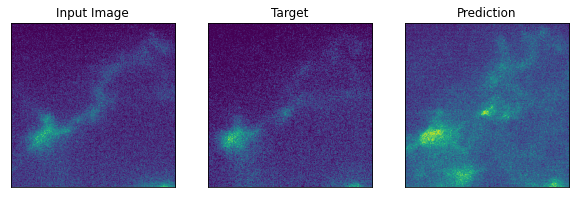

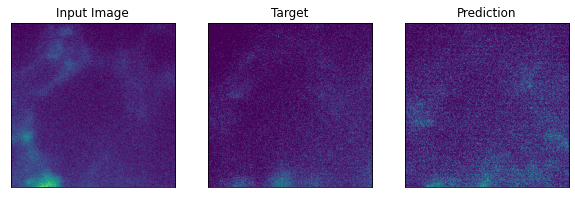

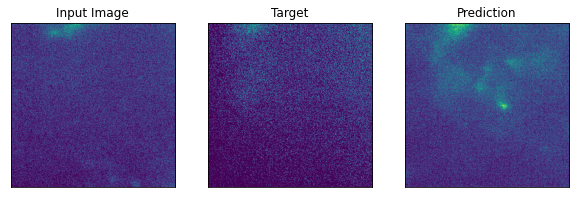

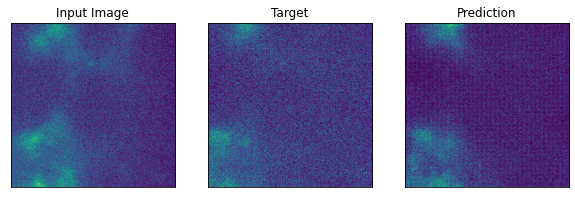

In [22]:
"""Show Results DDPM"""

N = 4

X,Y = next(iter(valid_loader))

X,Y = X.cuda(), Y.cuda()
model.cuda()

# pred = model.sample(Y[:N], batch_size=N)

def results(X,Y,pred, n, data_path = './results/light_sheets/full'):
    _,ax = plt.subplots(1,3, figsize=(10,10))

    X,Y,pred = X[0].detach().cpu(), Y[0].detach().cpu(), torch.clip(pred[0],0,None).detach().cpu()
    
    ax[0].imshow(X)
    ax[0].set_title('Input Image')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(Y)
    ax[1].set_title('Target')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].imshow(pred)
    ax[2].set_title('Prediction')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
#     plt.show()
    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    
    plt.savefig(os.path.join(data_path, f'result{n:02d}'))
    
for n in range(N):
    results(X[n],Y[n],pred[n],n)